# 🏋️  Exercise
Let's collect the stuff together and shoot at the target!

# 

We will go through **2** exercises here.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from itertools import product

## Exercise Set 1️⃣

In [ ]:
# Using skip rows because we have used the `names` paramer to rename to "sales"

df = pd.read_csv("../data/perrin-freres-monthly-champagne.csv", 
                index_col=0,
                parse_dates=True,
                names=["Sales"],
                skiprows=1, # skip rows will skip the header being read as data.
                skipfooter=2, # skip footer will skip the last 2 rows as they contain NaN
                engine='python')

df.index.freq = "MS"

In [ ]:
df.head()

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
df.shape

(105, 1)

Good.

###### 

So, now... *just forget* about what we did in the notebooks before. Like, did the manual sutff and so on. They were **absolutely** correct and to-the-point but here... if you start thinking about them then it will be a mess. 

**Here**, we are only gonna use the built-in method. Which will make the stuff much smoother and streamlined. Let's start with the data `viz`!

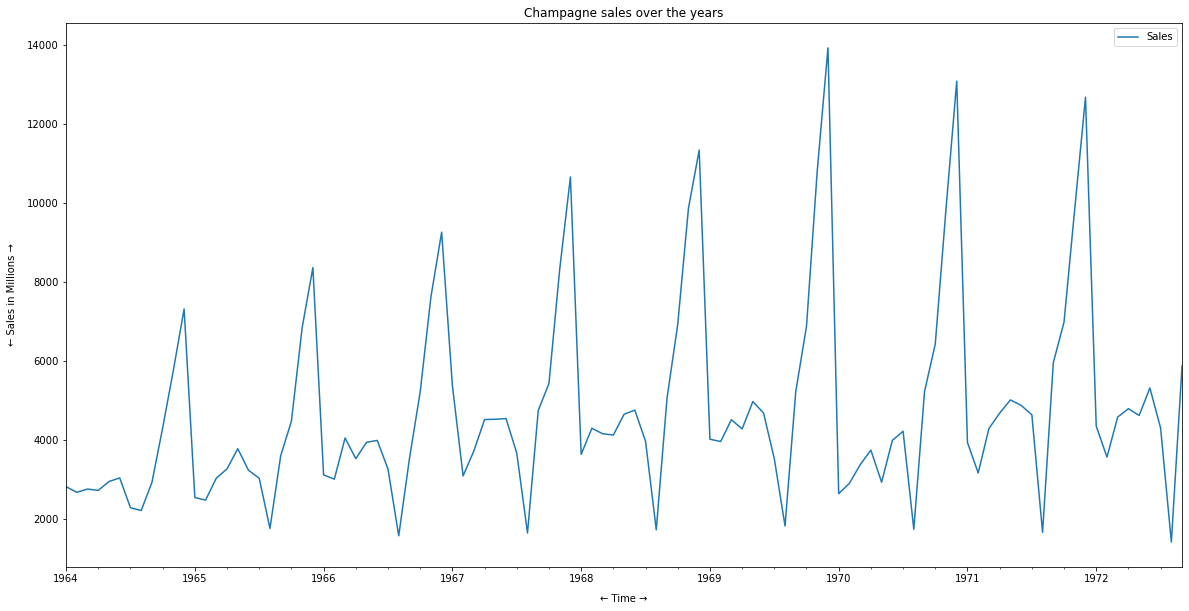

In [ ]:
df.plot()
plt.title("Champagne sales over the years")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Clearly it is a strong suggestion of a seasonal data. There are **regular** spikes in some month per year.
- It is observed that the sales kept increasing over the years till 1969 having a stopn **peak**
- After 1970, it looks it is falling.
- **It will be interesting** to see how it behaves after 1972 in our forecast period.

—

Again, I will be using the ***GridSearch*** here to find the best possible parameters for the testing. Once I am happy with that... I will use those settings to train it on **whole dataset** and then will forecast in the future. 

Since, this data is showing the pattern in the **yearly** setting, I will be keeping it `12` as the period.

In [ ]:
h = 12
offset = 1
def walkforward(
    trend_type,
    season_type,
    init_method,
    use_boxcox,
    debug=False):
    
    """
    This function should be called either individually or from the 
    grid search (the manual one).
    
    What is does is, it will fit and validate the model sotring the 
    errors of each fold in the errors list.
    
    Returns the mean of errors.
    """
    errors = []
    for th, idx in enumerate(range(70, len(df) + 1 - h, offset)):
        # Two simple parts
        train = df.iloc[:idx]
        test = df.iloc[idx:idx+h]
        
        # The model initialization of the parameters 
        model = ExponentialSmoothing(train, 
                                    trend=trend_type,
                                    seasonal=season_type,
                                    initialization_method=init_method,
                                    use_boxcox=use_boxcox,
                                    seasonal_periods=12)
        # Learning
        result = model.fit()
        
        # Getting the forecast results
        forecast = result.forecast(h)
        
        # Storing the error
        error = mean_absolute_percentage_error(test, forecast)
        errors.append(error)
        
    if debug:
        print("Total", th + 1, "steps!")
            
    return np.mean(errors) * 100

In [ ]:
walkforward("add", "mul", "estimated", True, True)

Total 24 steps!


17.285805330097705

So, this simple version does `17%` error in the data. Let's get things running for the GridSearch.

### Defining the list of the parameters

In [ ]:
list_of_parameters = \
[
    ["add", "mul"],
    ["add", "mul"],
    ["estimated", "heuristic", "legacy-heuristic"],
    [True, False]
]

In [ ]:
# Total possible combinations
2 * 2 * 3 * 2

24

In [ ]:
def gridSearch(list_of_parameters):
    best_score = float('inf') # NEW!
    best_hyperparams = None
    
    for th, parameters in enumerate(product(*list_of_parameters)):
        print(th + 1, "/24", sep="")
        score = walkforward(*parameters)
        
        if score < best_score:
            best_score = score
            best_hyperparams = parameters
            
    return best_score, best_hyperparams

In [ ]:
best_score, best_hyper = gridSearch(list_of_parameters)

1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24


In [ ]:
best_score

13.818154891884568

In [ ]:
best_hyper

('add', 'mul', 'legacy-heuristic', False)

### Simple Train and Test... see what happens 

In [ ]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [ ]:
model = ExponentialSmoothing(train,
                            trend="add",
                            seasonal="mul",
                            initialization_method="legacy-heuristic",
                            use_boxcox=False)

In [ ]:
result = model.fit()

In [ ]:
forecast = result.forecast(12)
forecast = pd.Series(forecast, index=test.index)

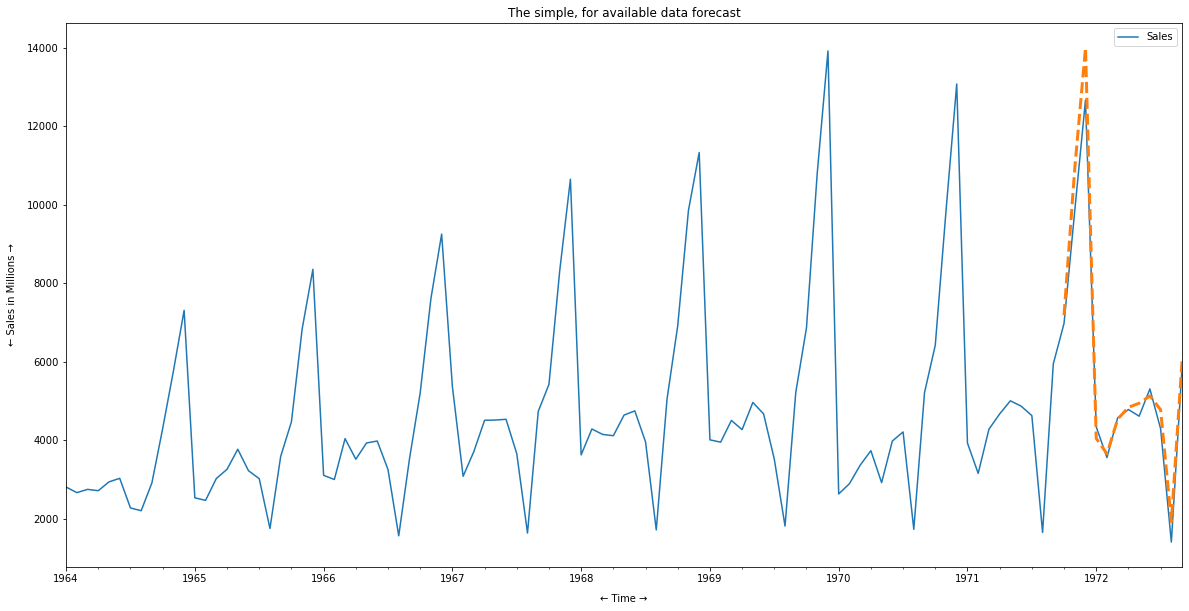

In [ ]:
df.plot()
forecast.plot(ls="--", lw=3)
plt.title("The simple, for available data forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

##### 

### 📈 A Real Forecast

In [ ]:
model = ExponentialSmoothing(df,
                            trend="add",
                            seasonal="mul",
                            initialization_method="legacy-heuristic",
                            use_boxcox=False)

result = model.fit()

In [ ]:
forecast = result.forecast(24)

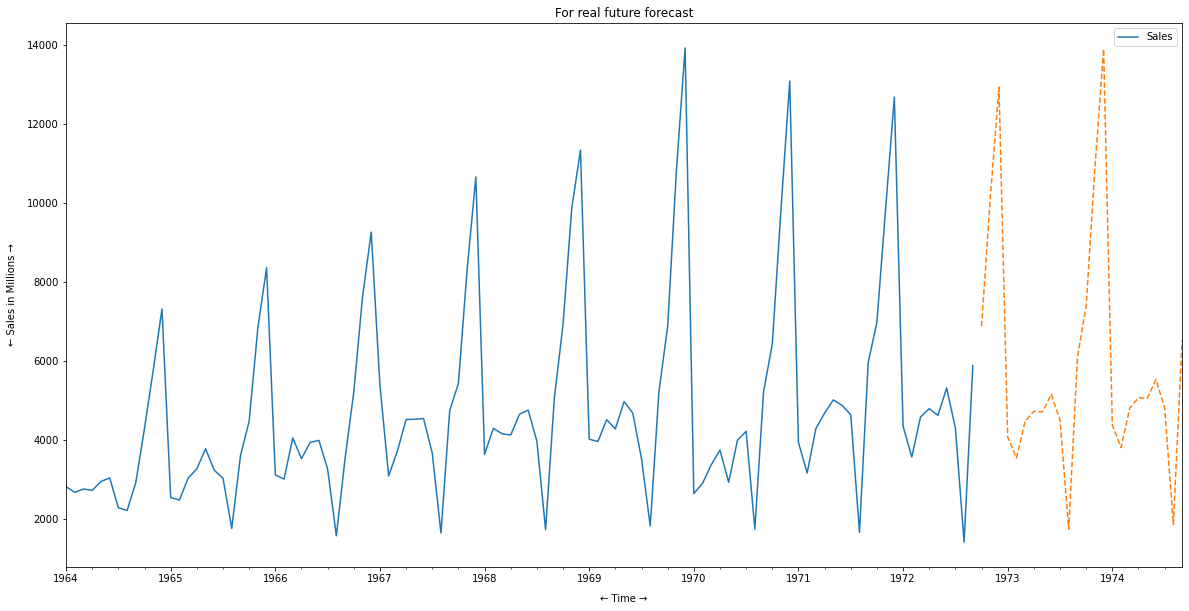

In [ ]:
df.plot()
forecast.plot(ls="--")
plt.title("For real future forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Only for `2` years ahead. **LOOKS FASCINATING!** Let's go for more!

In [ ]:
forecast = result.forecast(120) # 10 years

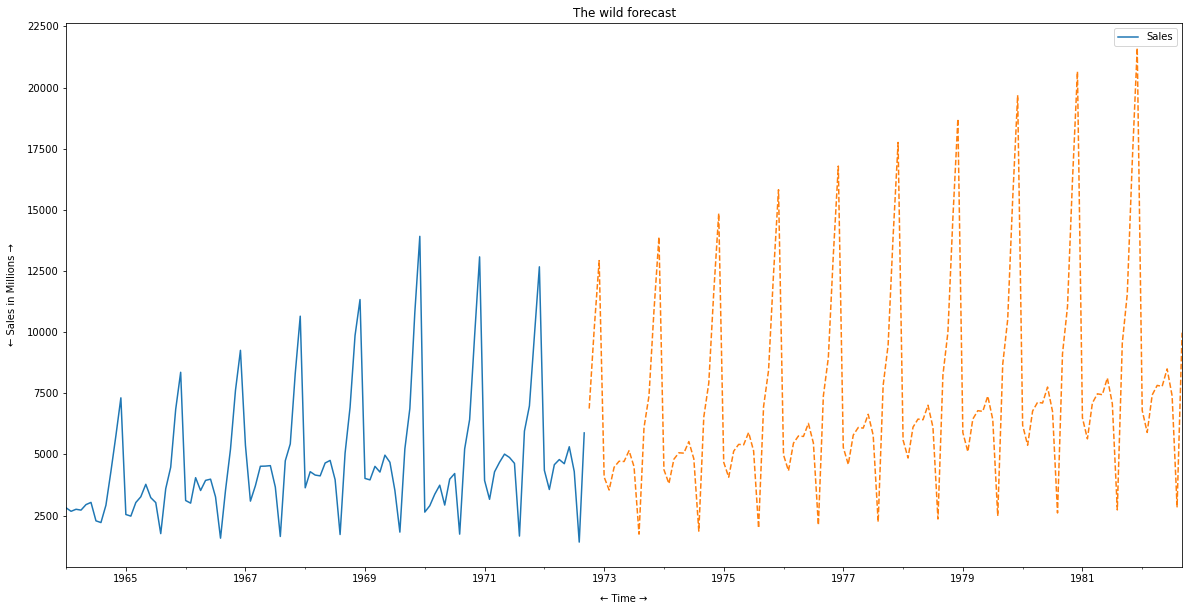

In [ ]:
df.plot()
forecast.plot(ls="--")
plt.title("The wild forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Bruh! It is increasing... let's try `add` as season!

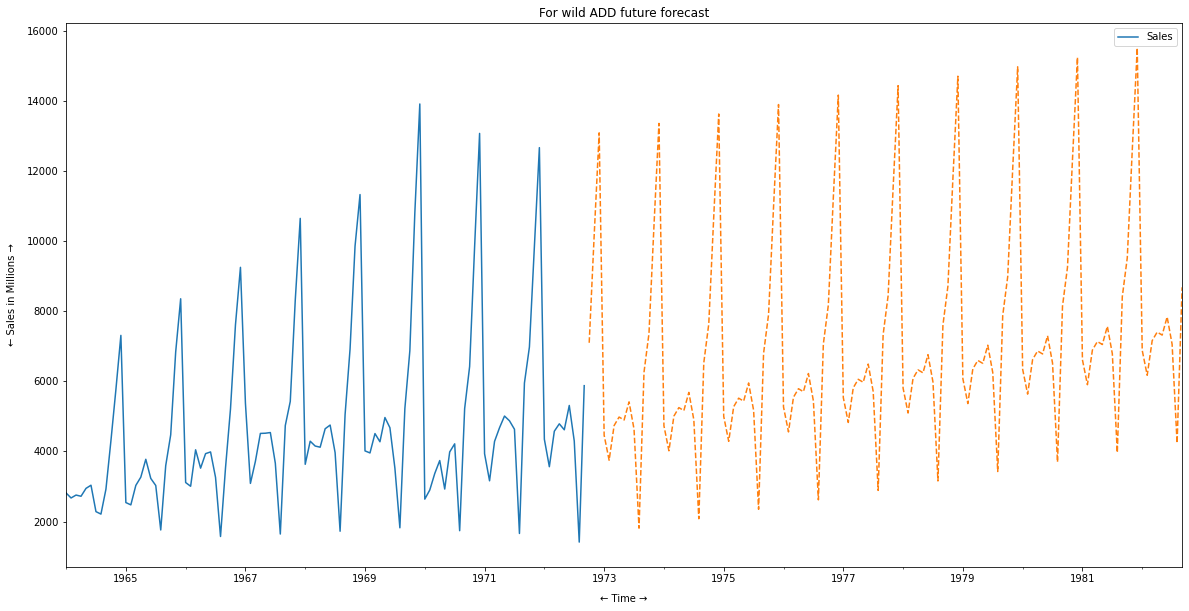

In [ ]:
model = ExponentialSmoothing(df,
                            trend="add",
                            seasonal="add",
                            initialization_method="legacy-heuristic",
                            use_boxcox=False)

result = model.fit()
forecast = result.forecast(120)

df.plot()
forecast.plot(ls="--")
plt.title("For wild ADD future forecast")
plt.xlabel("← Time →", labelpad=10)
plt.ylabel("← Sales in Millions →", labelpad=10);

Alright, the settings received by the GridSearch looks **better**!

# 

## Exercise Set 2️⃣

In [ ]:
df = pd.read_csv("../data/sp500_close.csv",
                 index_col=0,
                 parse_dates=True)

In [24]:
df["GOOGL"].isna().sum()

567

These are the holiday values, thus we can drop them.

In [31]:
google = df.GOOGL.dropna()
google.head()

2013-02-08    393.0777
2013-02-11    391.6012
2013-02-12    390.7403
2013-02-13    391.8214
2013-02-14    394.3039
Name: GOOGL, dtype: float64

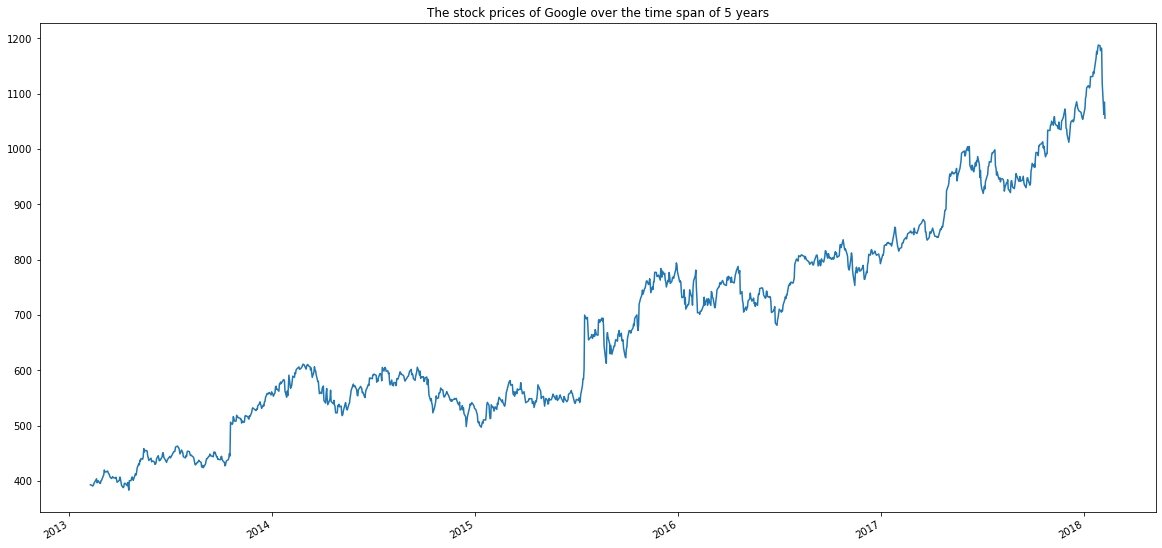

In [47]:
google.plot()
plt.title("The stock prices of Google over the time span of 5 years");

**Eye-ball analysis**:
- Right from here, we can see that Google is doing amazing job over the years.
- The trend is obviously on the positive side.
- After the mid 2015 it has shown constant positive growth.

### 🧠 Recall
Recall from the previous talks about the **random walk**. The stock prices mostly tend to follow a **random walk**. So, the ***best estimate for the forecast values is — the Naive forecast***.

Meaning, if we use some *sophisticated* models then that *might* be proved as a ***bad*** forecast. So, the moral of the story is that, we will have to check `4` techniques here:
1. Naive forecast *(copying last valeus)*
2. SES *(copying the values but learning the level)*
3. Holt's model *(no season, yes trend)*
4. Holt Winter's model *(yes season, yes trend)*

Here, we will check the `MAE` and `MAPE` score to evaluate the fit. Let's see how that goes.

> And, while doing the forecasting... did you get ***a small doubt***? That the transformations that we have learnt before, why aren't they being used here?

The answer is: **They do**! But the model does it internally. <br>
Meaning, *box-cox (which involves log and power)* is done internally but the model! With the `use_boxcox` parameter. So, no need to do them manually.

___

### 🤖 Training & Forecasting

In [39]:
# The train and test split
train = google.iloc[:-31]
test = google.iloc[-31:]

#### `1.` Simple Forecasting (Naive)

In [42]:
naive_forecast = pd.Series(np.repeat(train.iloc[-1], 31),
                           index=test.index)

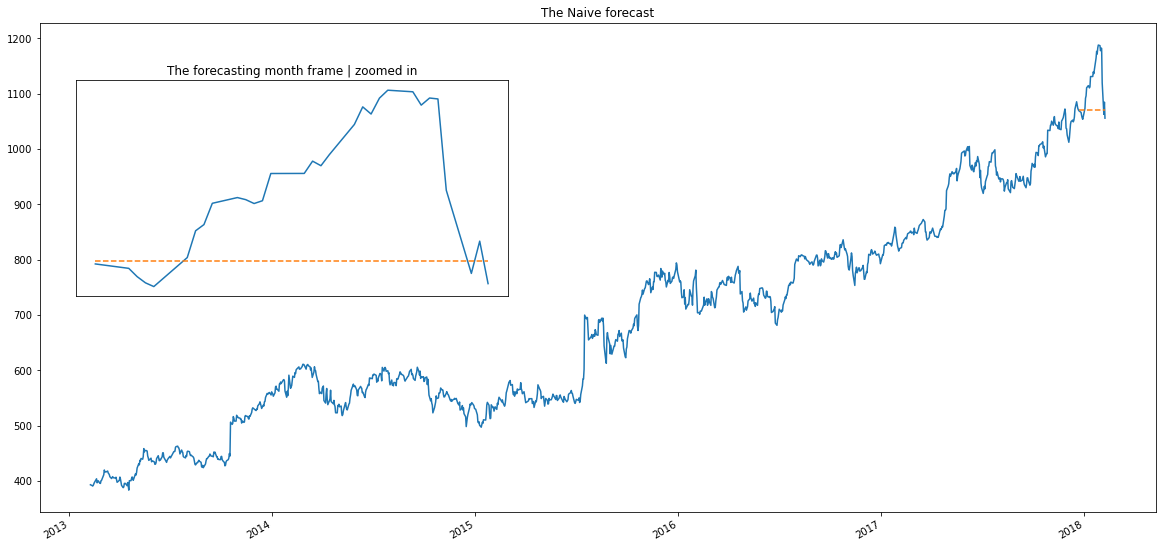

In [119]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])

google.plot(ax=main_axes)
naive_forecast.plot(ax=main_axes, ls='dashed')

google.iloc[-31:].plot(ax=small_axes)
naive_forecast.plot(ax=small_axes, ls='dashed')


main_axes.set(title="The Naive forecast");
small_axes.set(yticks=[], xticks=[],
               title="The forecasting month frame | zoomed in");

In [84]:
# Check the R2 and MAE
def get_metrics(true, forecast):
    print("MAPE:", round(mean_absolute_percentage_error(true, forecast) * 100, 4), "%")
    print("MAE:", mean_absolute_error(true, forecast))
    print("RMSE:", mean_squared_error(true, forecast, squared=False))

In [85]:
get_metrics(test, naive_forecast)

MAPE: 4.7237 %
MAE: 54.38677419354844
RMSE: 67.10660048782286


# 

#### `2.` Simple Exponential Smoothing
Here: *no trend, no seasonality*

In [86]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [120]:
SES_model = SimpleExpSmoothing(train, 
                               initialization_method='legacy-heuristic')

result = SES_model.fit()
SES_forecast = result.forecast(31).to_numpy()

In [121]:
SES_forecast = pd.Series(SES_forecast,
                           index=test.index)

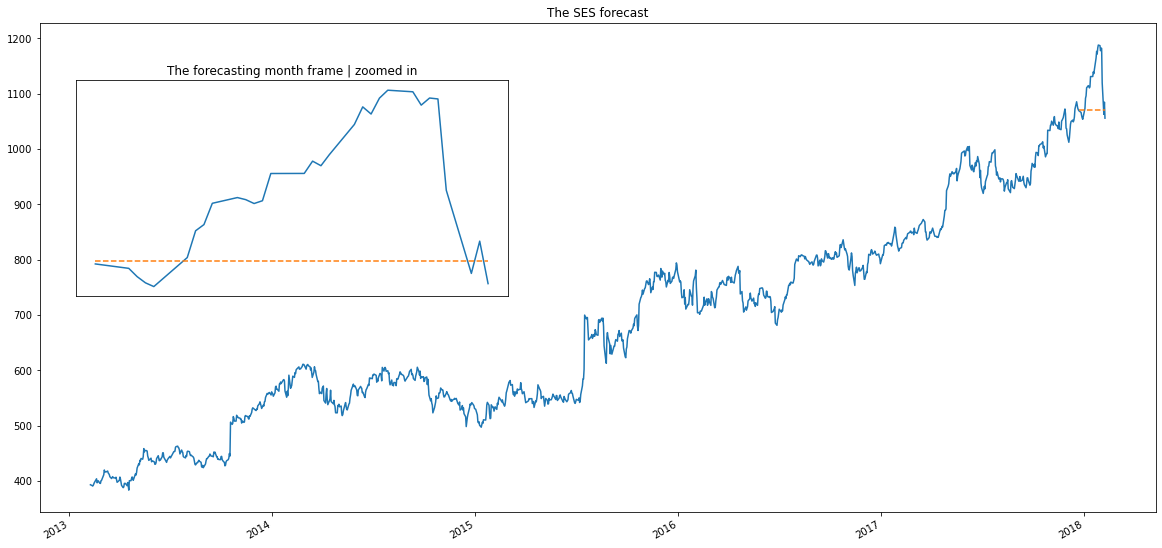

In [124]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])

google.plot(ax=main_axes)
SES_forecast.plot(ax=main_axes, ls='dashed')

google.iloc[-31:].plot(ax=small_axes)
SES_forecast.plot(ax=small_axes, ls='dashed')


main_axes.set(title="The SES forecast");
small_axes.set(yticks=[], xticks=[],
               title="The forecasting month frame | zoomed in");

In [125]:
get_metrics(test, SES_forecast)

MAPE: 4.7237 %
MAE: 54.38677417140346
RMSE: 67.10660045796376


Just the same! *(ignoring the last changes in the fractions)*

# 

#### `3.` Holt's Model
Here: *yes trend, no seasonality*

In [97]:
from statsmodels.tsa.holtwinters import Holt

In [126]:
Holt_model = Holt(train, 
                  initialization_method='legacy-heuristic')

result = Holt_model.fit()
Holt_forecast = result.forecast(31).to_numpy()

In [127]:
Holt_forecast = pd.Series(Holt_forecast,
                          index=test.index)

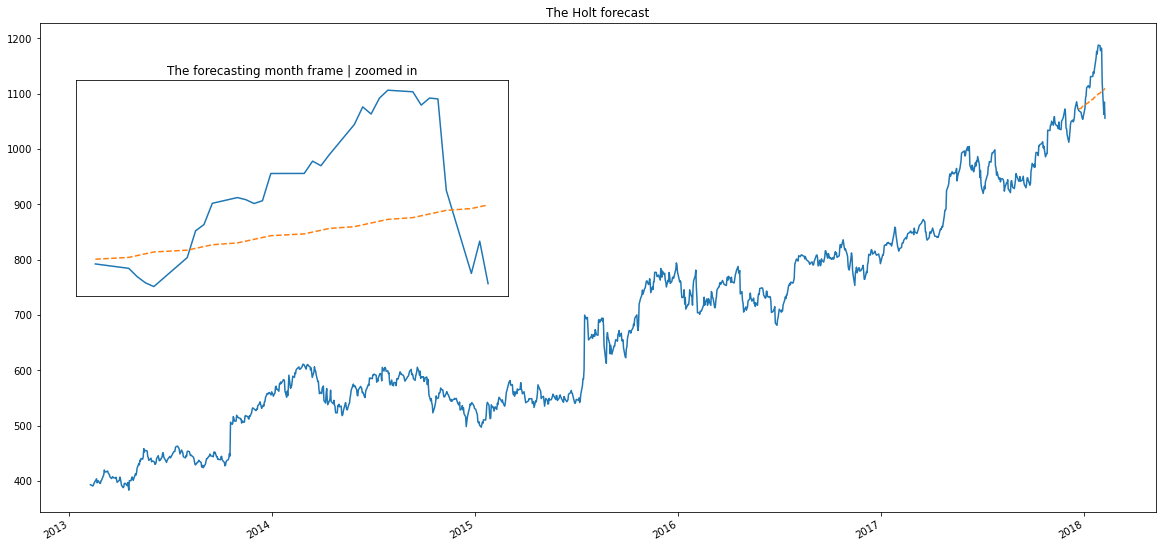

In [129]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])

google.plot(ax=main_axes)
Holt_forecast.plot(ax=main_axes, ls='dashed')

google.iloc[-31:].plot(ax=small_axes)
Holt_forecast.plot(ax=small_axes, ls='dashed')


main_axes.set(title="The Holt forecast");
small_axes.set(yticks=[], xticks=[],
               title="The forecasting month frame | zoomed in");

In [130]:
get_metrics(test, Holt_forecast)

MAPE: 3.7113 %
MAE: 42.43035515018394
RMSE: 50.32201920993565


We are doing better! The error is shrinked to **$42.32** *(considering MAE)*

In [131]:
# With `exponential=True` we are doing even better!

Holt_model = Holt(train, 
                  initialization_method='legacy-heuristic',
                  exponential=True)

result = Holt_model.fit()
Holt_forecast = result.forecast(31).to_numpy()

Holt_forecast = pd.Series(Holt_forecast,
                          index=test.index)

get_metrics(test, Holt_forecast)

MAPE: 3.5176 %
MAE: 40.11954214670733
RMSE: 47.387314827841166


See?

# 

#### `4.` Holt Winter's Model
Here: *yes trend, yes seasonality*

In [132]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [134]:
HW_model = ExponentialSmoothing(train, 
                                initialization_method='legacy-heuristic', 
                                trend="add",
                                seasonal="mul",
                                seasonal_periods=31)

result = HW_model.fit()
HW_forecast = result.forecast(31).to_numpy()

In [135]:
HW_forecast = pd.Series(HW_forecast,
                          index=test.index)

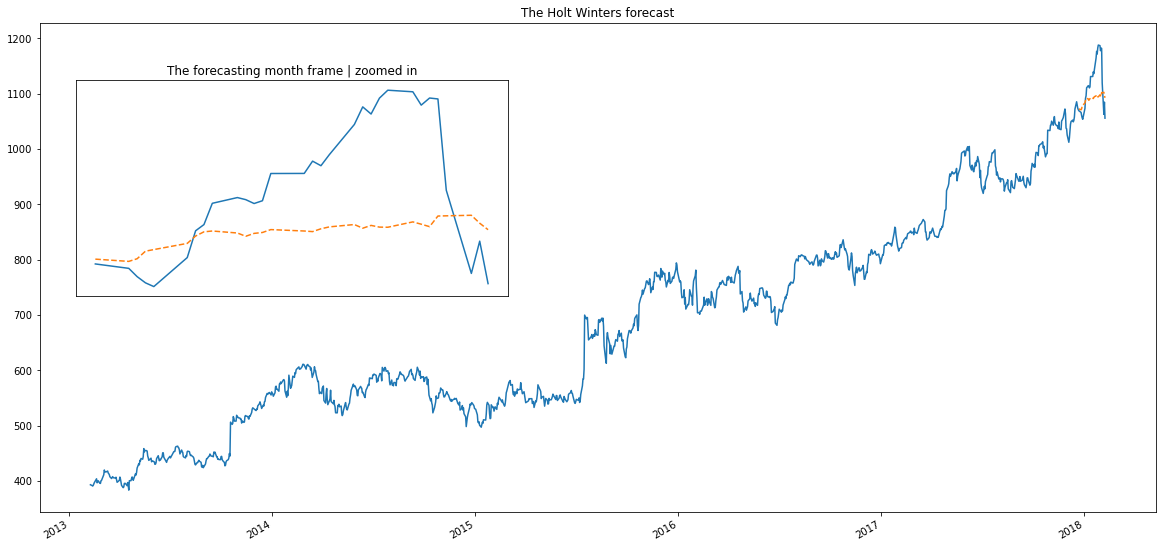

In [136]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])

google.plot(ax=main_axes)
HW_forecast.plot(ax=main_axes, ls='dashed')

google.iloc[-31:].plot(ax=small_axes)
HW_forecast.plot(ax=small_axes, ls='dashed')


main_axes.set(title="The Holt Winters forecast");
small_axes.set(yticks=[], xticks=[],
               title="The forecasting month frame | zoomed in");

In [137]:
get_metrics(test, Holt_forecast)

MAPE: 3.5176 %
MAE: 40.11954214670733
RMSE: 47.387314827841166


It is the **best so far**. <br>
But still I want to try other parameters. So we will use our GridSearch!

In [157]:
list_of_parameters = \
[
    ["add", "mul", None],
    ["add", "mul", None],
    ["estimated", "heuristic", "legacy-heuristic"],
    [True, False],
    [7, 31, 90, 180, 365]
    # W, M, 3M,  6M,  1Y
]

In [158]:
# Total combinations!
3 * 3 * 3 * 2 * 5

270

We are not using the WalkForward here, it would take so much time.

In [169]:
def gridSearch(list_of_parameters):
    best_score = float('inf') # NEW!
    best_hyperparams = None
    
    for th, parameters in enumerate(product(*list_of_parameters)):
        print(th + 1, "/270", sep="", end="\t")
        
        trend_type, season_type, init_method, use_boxcox, h = parameters
        model = ExponentialSmoothing(train, 
                                    trend=trend_type,
                                    seasonal=season_type,
                                    initialization_method=init_method,
                                    use_boxcox=use_boxcox,
                                    seasonal_periods=h)
        # Learning
        result = model.fit()
        
        # Getting the forecast results
        forecast = result.forecast(31)
        
        # Storing the error
        score = mean_absolute_error(test, forecast) # changed to MAE from MAPE
        
        if score < best_score:
            best_score = score
            best_hyperparams = parameters
            
    return best_score, best_hyperparams

In [170]:
best_score, best_hypers = gridSearch(list_of_parameters)

1/270	2/270	3/270	4/270	5/270	6/270	7/270	8/270	9/270	10/270	11/270	12/270	13/270	14/270	15/270	16/270	17/270	18/270	19/270	20/270	21/270	22/270	23/270	24/270	25/270	26/270	27/270	28/270	29/270	30/270	31/270	32/270	33/270	34/270	35/270	36/270	37/270	38/270	39/270	40/270	41/270	42/270	43/270	44/270	45/270	46/270	47/270	48/270	49/270	50/270	51/270	52/270	53/270	54/270	55/270	56/270	57/270	58/270	59/270	60/270	61/270	62/270	63/270	64/270	65/270	66/270	67/270	68/270	69/270	70/270	71/270	72/270	73/270	74/270	75/270	76/270	77/270	78/270	79/270	80/270	81/270	82/270	83/270	84/270	85/270	86/270	87/270	88/270	89/270	90/270	91/270	92/270	93/270	94/270	95/270	96/270	97/270	98/270	99/270	100/270	101/270	102/270	103/270	104/270	105/270	106/270	107/270	108/270	109/270	110/270	111/270	112/270	113/270	114/270	115/270	116/270	117/270	118/270	119/270	120/270	121/270	122/270	123/270	124/270	125/270	126/270	127/270	128/270	129/270	130/270	131/270	132/270	133/270	134/270	135/270	136/270	137/270	138/270	139/

In [171]:
best_score

19.677764466086796

In [172]:
best_hypers

(None, 'add', 'legacy-heuristic', True, 365)

Nice!

In [173]:
365 * 2

730

I would still doubt the `h = 365`.  Let's increase it to 730 *(2 years)* and see if that makes difference.

In [177]:
final_model = ExponentialSmoothing(train, 
                                    trend=None,
                                    seasonal='add',
                                    initialization_method='legacy-heuristic',
                                    use_boxcox=True,
                                    seasonal_periods=730)
# Learning
result = final_model.fit()
forecast = result.forecast(31)
mean_absolute_error(test, forecast)

40.332984072626736

Nah! It increases! So, `365` is better!

In [181]:
final_model = ExponentialSmoothing(train, 
                                    trend=None,
                                    seasonal='add',
                                    initialization_method='legacy-heuristic',
                                    use_boxcox=True,
                                    seasonal_periods=365)
# Learning
result = final_model.fit()
final_forecast = result.forecast(31).to_numpy()
final_forecast = pd.Series(final_forecast,
                          index=test.index)

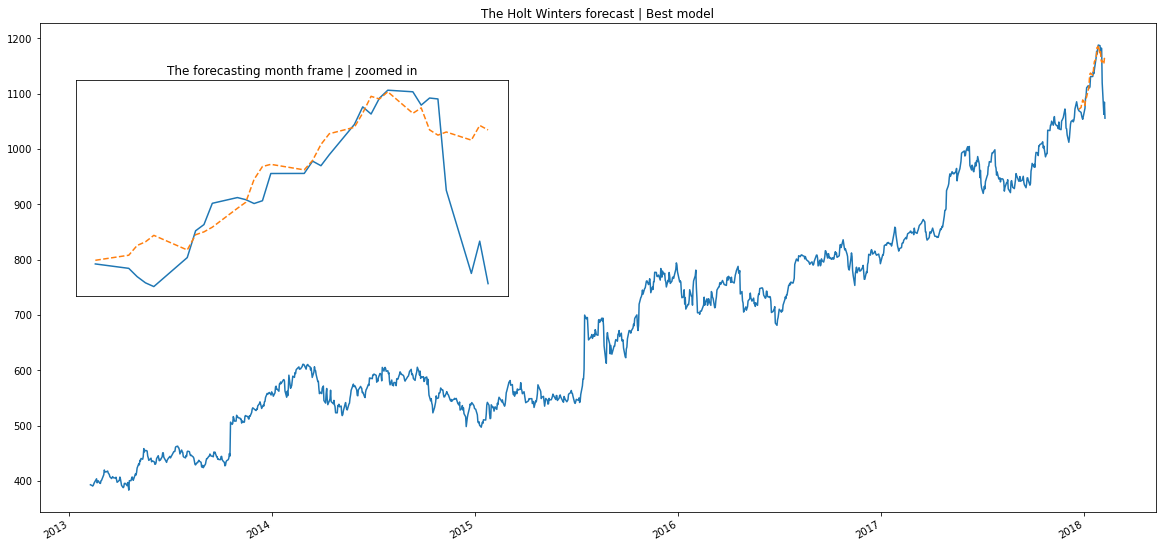

In [183]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])

google.plot(ax=main_axes)
final_forecast.plot(ax=main_axes, ls='dashed')

google.iloc[-31:].plot(ax=small_axes)
final_forecast.plot(ax=small_axes, ls='dashed')


main_axes.set(title="The Holt Winters forecast | Best model");
small_axes.set(yticks=[], xticks=[],
               title="The forecasting month frame | zoomed in");

In [185]:
get_metrics(test, final_forecast)

MAPE: 1.8023 %
MAE: 19.677764466086796
RMSE: 32.549909529174634


### 😍 How amazing!

Let's make it to the ***future***!

In [196]:
final_model = ExponentialSmoothing(google, # on whole data
                                    trend=None,
                                    seasonal='add',
                                    initialization_method='legacy-heuristic',
                                    use_boxcox=True,
                                    seasonal_periods=365)
# Learning
result = final_model.fit()

In [197]:
final_forecast = result.forecast(365).to_numpy()
final_forecast = pd.Series(final_forecast,
                          index=pd.date_range(google.index[-1], periods=365))

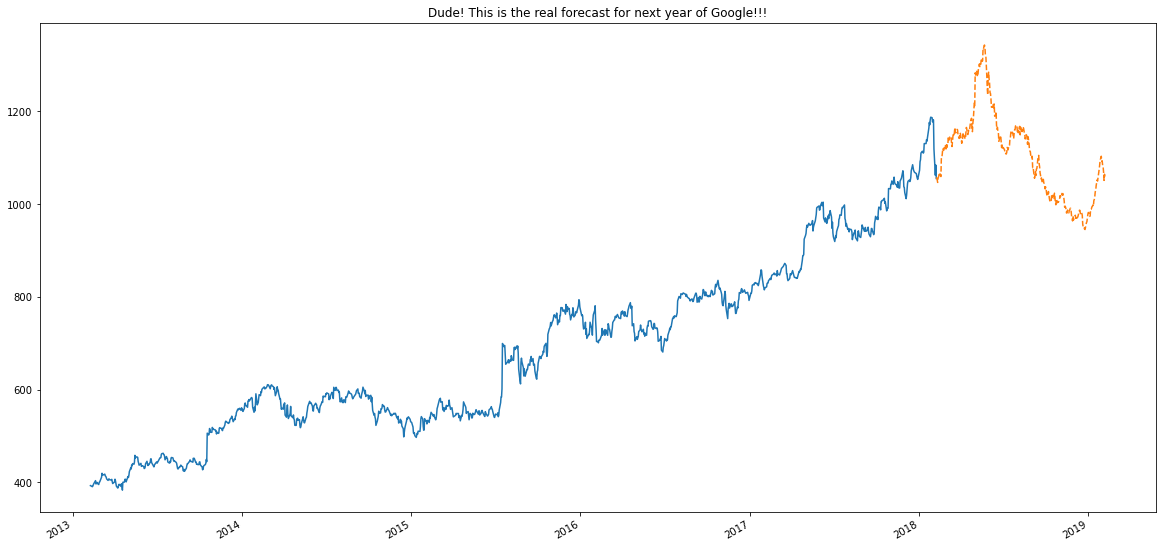

In [201]:
google.plot()
final_forecast.plot(ls='dashed')
plt.title("Dude! This is the real forecast for next year of Google!!!");

In [202]:
final_forecast = result.forecast(365 * 3).to_numpy()
final_forecast = pd.Series(final_forecast,
                          index=pd.date_range(google.index[-1], periods=365 * 3))

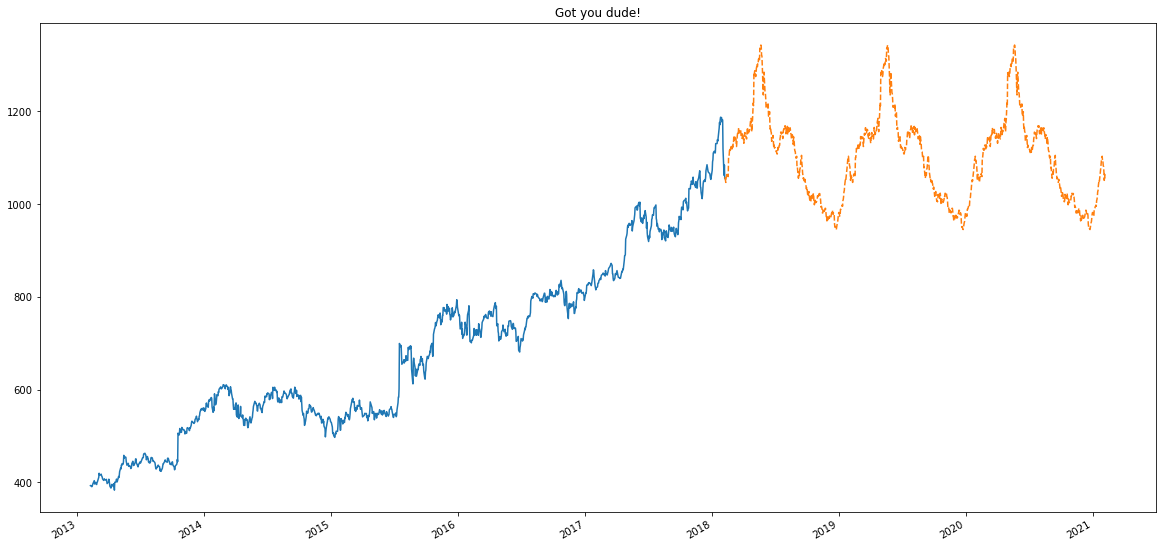

In [204]:
google.plot()
final_forecast.plot(ls='dashed')
plt.title("Got you dude!");

# 

# Great, Great Stuff!
I loved to see things in action. Let's meet in the next section! 